# TP1 - Preço de Carros Usados (Kaggle)
Este notebook documenta o processo de resolução da competição privada 'Preço de Carros Usados' no Kaggle. O objetivo é prever o preço de carros usados utilizando diferentes modelos de aprendizagem automática, começando por Regressão Linear.

## 1. Importação das bibliotecas necessárias

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

## 2. Carregamento e exploração inicial dos dados

In [2]:
# Carregar os dados de treino e teste
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Guardar os IDs do conjunto de teste
test_ids = test['id'].copy()
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


## 3. Análise exploratória dos dados

In [3]:
# Informações gerais
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


## 4. Pré-processamento dos dados

In [4]:
# Remover coluna 'id' (não informativa)
train = train.drop(columns=['id'])

# Extrair informações da coluna 'engine'
def extrair_horsepower(engine):
    if pd.isnull(engine): return np.nan
    match = re.search(r'(\d+(?:\.\d+)?)\s*HP', str(engine))
    return float(match.group(1)) if match else np.nan

def extrair_engine_size(engine):
    if pd.isnull(engine): return np.nan
    match = re.search(r'(\d+(?:\.\d+)?)\s*L', str(engine))
    return float(match.group(1)) if match else np.nan

def extrair_cylinders(engine):
    if pd.isnull(engine): return np.nan
    match = re.search(r'(\d+)\s*Cylinder', str(engine))
    return int(match.group(1)) if match else np.nan

for df in [train, test]:
    if 'engine' in df.columns:
        df['horsepower'] = df['engine'].apply(extrair_horsepower)
        df['engine_size'] = df['engine'].apply(extrair_engine_size)
        df['cylinders'] = df['engine'].apply(extrair_cylinders)
        df.drop('engine', axis=1, inplace=True)

# Criar novas features (incluindo log_milage e bins)
bins = [0, 20000, 50000, 100000, 200000, np.inf]
labels = ['<20k', '20–50k', '50–100k', '100–200k', '>200k']

for df in [train, test]:
    if 'model_year' in df.columns:
        df['car_age'] = 2025 - df['model_year']
    if 'milage' in df.columns:
        df['milage'] = pd.to_numeric(df['milage'], errors='coerce')
        df.loc[df['milage'] < 0, 'milage'] = np.nan
        df['milage'] = df['milage'].replace(0, np.nan)
        df['log_milage'] = np.log1p(df['milage'])
        df['milage_bin'] = pd.cut(df['milage'], bins=bins, labels=labels, include_lowest=True)
    if 'price' in df.columns:
        df['price_per_km'] = df['price'] / df['milage']

# Colunas categóricas (apenas as que existem no dataset)
base_cat_cols = ['brand', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'milage_bin']
cat_cols = [c for c in base_cat_cols if c in train.columns]

# Codificar variáveis categóricas
train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)

# Alinhar as colunas de train e test (mesmo número e ordem)
train, test = train.align(test, join='left', axis=1, fill_value=0)

# Label Encoding para colunas específicas
for col in ['accident', 'clean_title']:
    if col in train.columns and col in test.columns:
        le = LabelEncoder()
        combined = pd.concat([train[col], test[col]], axis=0).astype(str)
        le.fit(combined)
        train[col] = le.transform(train[col].astype(str))
        test[col] = le.transform(test[col].astype(str))

# Normalizar variáveis numéricas (incluindo log_milage se existir)
num_cols = [c for c in ['milage', 'model_year', 'horsepower', 'engine_size', 'car_age', 'price_per_km', 'log_milage'] if c in train.columns]

scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

# Remover outliers da coluna price (apenas no train)
if 'price' in train.columns:
    Q1 = train['price'].quantile(0.25)
    Q3 = train['price'].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    train = train[(train['price'] >= limite_inferior) & (train['price'] <= limite_superior)]

# Remover NaN no train, preencher no test
train.dropna(inplace=True)
test = test.fillna(0)

print("Train final shape:", train.shape)
print("Test final shape:", test.shape)
train


Train final shape: (143641, 602)
Test final shape: (125690, 602)


,model,model_year,milage,accident,clean_title,price,horsepower,engine_size,cylinders,car_age,...,int_col_Walnut,int_col_Whisper Beige,int_col_White,int_col_White / Brown,int_col_Yellow,int_col_–,milage_bin_20–50k,milage_bin_50–100k,milage_bin_100–200k,milage_bin_>200k
0,Cooper S Base,-1.559808,2.957842,1,0,4200,-1.492706,-1.608472,4.0,1.559808,...,False,False,False,False,False,False,False,False,False,True
1,LS V8,-2.443052,1.557184,0,0,4999,-0.795440,0.092131,8.0,2.443052,...,False,False,False,False,False,False,False,False,True,False
2,Silverado 2500 LT,-2.443052,1.426276,1,0,13900,-0.202764,1.127281,8.0,2.443052,...,False,False,False,False,False,False,False,False,True,False
3,G90 5.0 Ultimate,0.206679,-0.927854,1,0,45000,0.668819,0.905463,8.0,-0.206679,...,False,False,False,False,False,False,False,False,False,False
4,Metris Base,0.913274,-1.171076,1,0,97500,-1.178936,-1.312715,4.0,-0.913274,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188527,Camaro Z28,-2.972998,0.889487,1,0,14500,-0.289922,1.423038,8.0,2.972998,...,False,False,False,False,False,False,False,False,True,False
188528,Escalade ESV Platinum,0.206679,-0.335461,1,0,27500,0.668819,1.792734,8.0,-0.206679,...,False,False,False,False,False,False,True,False,False,False
188529,AMG C 43 AMG C 43 4MATIC,0.383328,-0.745116,0,0,30000,0.363765,-0.573322,6.0,-0.383328,...,False,False,False,False,False,False,True,False,False,False
188530,AMG GLC 63 Base 4MATIC,0.913274,-1.045328,1,0,86900,1.095894,0.166070,8.0,-0.913274,...,False,False,False,False,False,False,False,False,False,False


## 5. Modelo de Regressão Linear

Formato de X: (143641, 2427)
Formato de y_log: (143641,)
Tipos ainda não numéricos em X: Series([], dtype: object)
Formato de X_train_final: (114912, 2442)
Formato de X_val_final: (28729, 2442)
Formato de X_train_final: (114912, 2442)
Formato de X_val_final: (28729, 2442)
MSE (val): 168818394.55
R²  (val): 0.6206
MSE (val): 168818394.55
R²  (val): 0.6206


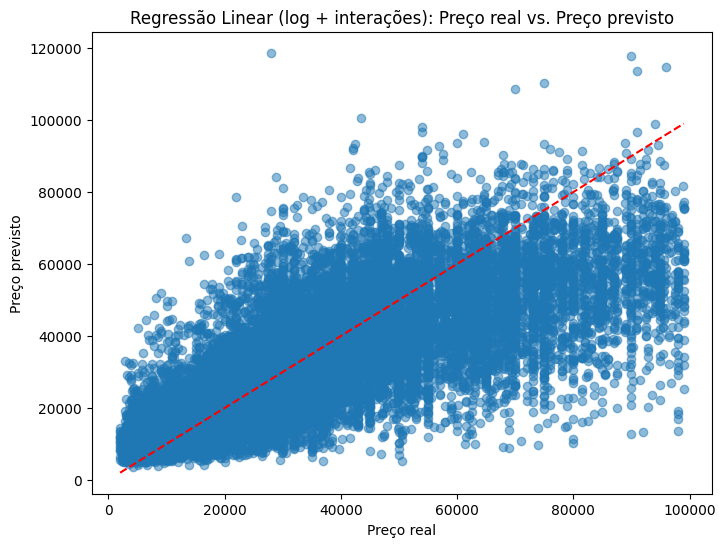

In [5]:
# ---------- PARTE A: AVALIAÇÃO COM TRAIN_TEST_SPLIT ----------

# 1. Definir X e y a partir do train tratado
cols_excluir = ['price']
if 'price_per_km' in train.columns:
    cols_excluir.append('price_per_km')

X = train.drop(columns=cols_excluir, errors='ignore')
y = train['price']

# aplicar log(1 + price) para estabilizar a variância dos preços
y_log = np.log1p(y)

# garantir que não há colunas de texto – aplicar get_dummies em tudo o que for categórico
X = pd.get_dummies(X, drop_first=True)

print("Formato de X:", X.shape)
print("Formato de y_log:", y_log.shape)
print("Tipos ainda não numéricos em X:", X.dtypes[X.dtypes == "object"])

# 2. Dividir em treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X, y_log,
    test_size=0.2,
    random_state=42
)

# 2.1 Criar features polinomiais (interações) para algumas colunas numéricas
from sklearn.preprocessing import PolynomialFeatures

num_cols_poly = [c for c in ['milage', 'horsepower', 'engine_size', 'car_age', 'km_per_year', 'cylinders'] if c in X_train.columns]

poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_num = poly.fit_transform(X_train[num_cols_poly])
X_val_num = poly.transform(X_val[num_cols_poly])

# converter de volta para DataFrame
poly_feature_names = poly.get_feature_names_out(num_cols_poly)
X_train_num_df = pd.DataFrame(X_train_num, index=X_train.index, columns=poly_feature_names)
X_val_num_df = pd.DataFrame(X_val_num, index=X_val.index, columns=poly_feature_names)

# remover as colunas numéricas originais e juntar as polinomiais
X_train_rest = X_train.drop(columns=num_cols_poly)
X_val_rest = X_val.drop(columns=num_cols_poly)

X_train_final = pd.concat([X_train_rest, X_train_num_df], axis=1)
X_val_final = pd.concat([X_val_rest, X_val_num_df], axis=1)

print("Formato de X_train_final:", X_train_final.shape)
print("Formato de X_val_final:", X_val_final.shape)

# 3. Treinar o modelo de Regressão Linear
lr = LinearRegression()
lr.fit(X_train_final, y_train)

# 4. Prever e avaliar (voltando à escala original)
y_pred_log = lr.predict(X_val_final)
y_pred = np.expm1(y_pred_log)
y_val_original = np.expm1(y_val)

mse = mean_squared_error(y_val_original, y_pred)
r2 = r2_score(y_val_original, y_pred)

print(f'MSE (val): {mse:.2f}')
print(f'R²  (val): {r2:.4f}')

# 5. Gráfico: preço real vs previsto
plt.figure(figsize=(8,6))
plt.scatter(y_val_original, y_pred, alpha=0.5)
plt.xlabel('Preço real')
plt.ylabel('Preço previsto')
plt.title('Regressão Linear (log + interações): Preço real vs. Preço previsto')
plt.plot([y_val_original.min(), y_val_original.max()],
         [y_val_original.min(), y_val_original.max()],
         'r--')
plt.show()


In [6]:
# ---------- PARTE B: TREINO FINAL + PREVISÃO NO TEST ----------

# garante que fizeste isto lá em cima, antes do tratamento:
# test_ids = test['id'].copy()

# 1. X_full (train completo) e X_test, sem as colunas a excluir
X_full = train.drop(columns=cols_excluir, errors='ignore')
y_full = train['price']
X_test = test.drop(columns=cols_excluir, errors='ignore')

# 2. Aplicar get_dummies em conjunto para alinhar categorias entre train e test
X_combined = pd.concat([X_full, X_test], axis=0)
X_combined = pd.get_dummies(X_combined, drop_first=True)

X_full = X_combined.iloc[:len(train), :]
X_test = X_combined.iloc[len(train):, :]

print("Formato de X_full:", X_full.shape)
print("Formato de y_full:", y_full.shape)
print("Formato de X_test:", X_test.shape)

# 3. Criar mesmas features polinomiais usadas na Parte A
num_cols_poly = [c for c in ['milage', 'horsepower', 'engine_size', 'car_age', 'km_per_year', 'cylinders'] if c in X_full.columns]

poly = PolynomialFeatures(degree=2, include_bias=False)

X_full_num = poly.fit_transform(X_full[num_cols_poly])
X_test_num = poly.transform(X_test[num_cols_poly])

poly_feature_names = poly.get_feature_names_out(num_cols_poly)
X_full_num_df = pd.DataFrame(X_full_num, index=X_full.index, columns=poly_feature_names)
X_test_num_df = pd.DataFrame(X_test_num, index=X_test.index, columns=poly_feature_names)

X_full_rest = X_full.drop(columns=num_cols_poly)
X_test_rest = X_test.drop(columns=num_cols_poly)

X_full_final = pd.concat([X_full_rest, X_full_num_df], axis=1)
X_test_final = pd.concat([X_test_rest, X_test_num_df], axis=1)

print("Formato de X_full_final:", X_full_final.shape)
print("Formato de X_test_final:", X_test_final.shape)

# 4. Transformar alvo para log(1 + price) e treinar modelo final
y_full_log = np.log1p(y_full)

lr_final = LinearRegression()
lr_final.fit(X_full_final, y_full_log)

# 5. Prever no test (em log) e voltar à escala original
y_test_pred_log = lr_final.predict(X_test_final)
y_test_pred = np.expm1(y_test_pred_log)

# 6. Criar o DataFrame de submissão (usar test_ids, não X_test['id'])
submission = pd.DataFrame({
    'id': test_ids,
    'price': y_test_pred
})

# 7. Guardar o CSV de submissão
submission.to_csv('submission.csv', index=False, float_format='%.2f')


Formato de X_full: (143641, 2495)
Formato de y_full: (143641,)
Formato de X_test: (125690, 2495)
Formato de X_full_final: (143641, 2510)
Formato de X_test_final: (125690, 2510)
Formato de X_full_final: (143641, 2510)
Formato de X_test_final: (125690, 2510)
